In [29]:
import awkward
import xgboost
import argparse
import glob
import numpy as np
import os
import json
import itertools
import vector
%pip install sklearn
from sklearn import metrics
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc,recall_score,precision_score

Note: you may need to restart the kernel to use updated packages.


In [30]:
from operator import itemgetter

def get_importance(gbm, features):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=itemgetter(1), reverse=True)
    return importance

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()
    
    
    

In [62]:
    input_dir="test_Data_2017_photon_cleaning"#"test_mva_training_7" 
    output_dir="test_training" 
    config="diphoton_bdt_config.json"
    nominal = input_dir + "/merged_nominal.parquet"
    data_file = "test_Data_2017_photon_cleaning" + "/merged_nominal.parquet"
    
    events = []
    events = awkward.from_parquet(nominal) 
    events = awkward.values_astype(events, np.float64)
    data   = events[events.process_id==0]
    events = events[events.process_id>0]
    
    norm = awkward.sum(events.weight_central_no_lumi)
    
    with open(config, "r") as f_in:
        bdt_config = json.load(f_in)


    with open(input_dir + "/summary.json", "r") as f_in:
        process_map = json.load(f_in)["sample_id_map"]

    # Anchor by diphoton_eta
    eta_fields = [x for x in bdt_config["features"] if "eta" in x]
    #for field in bdt_config["features"]:
    #    if "dZ" in field:
    #        events[field] = events[field] * np.sign(events[field])
    for field in eta_fields:
        events[field] = events[field] * np.sign(events.Diphoton_eta)

    # Add label
    events["train_label"] = awkward.ones_like(events.event) * -1

    print("[HiggsDNABonusTool] Found processes by the following proc ids: ")
    for proc, id in process_map.items():
        if proc == "Data":
            cat = proc
            label = -1
        elif proc in bdt_config["signal"]:
            cat = "Signal"
            label = 1
        elif proc in bdt_config["background"]:
            cat = "Background"
            label = 0
        else:
            continue
        print("\t %s : %s (%s)" % (proc, str(id), cat))

        events["train_label"] = awkward.where(
                events.process_id == id,
                awkward.ones_like(events.train_label) * label,
                events.train_label
        )

    print("[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.")

    print("[HiggsDNABonusTool] Out of %d total events, found %d signal and %d background events." % (len(events), len(events[events.train_label == 1]), len(events[events.train_label == 0])))

    # Add test/train/val split     
    split = np.random.randint(3, size = len(events))
    events["train_split"] = awkward.from_numpy(split) # 0 = train, 1 = test, 2 = validation

    events = awkward.nan_to_num(events, nan=-999., posinf=-999., neginf=-999.)
    print(len(events[events["train_split"]==0]), len(events[events["train_split"]==1]), len(events[events["train_split"]==1]))
    integral = awkward.sum(events.weight_central_no_lumi[events["train_split"]>0])

[HiggsDNABonusTool] Found processes by the following proc ids: 
	 Data : 0 (Data)
	 DiPhoton_M40_80 : 5 (Background)
	 DiPhoton_MGG-80-inf : 6 (Background)
	 GJets_HT-100To200 : 9 (Background)
	 GJets_HT-200To400 : 10 (Background)
	 GJets_HT-400To600 : 11 (Background)
	 GJets_HT-40To100 : 8 (Background)
	 GJets_HT-600ToInf : 12 (Background)
	 QCD : 7 (Background)
	 VBFH_M125 : 4 (Signal)
	 VH_M125 : 2 (Signal)
	 ggH_M125 : 1 (Signal)
	 ttH_M125 : 3 (Signal)
[HiggsDNABonusTool] Processes marked as 'Signal' or 'Background' will be used to train the BDT as signal and background, respectively.
[HiggsDNABonusTool] Out of 5549631 total events, found 4337514 signal and 1212117 background events.
1850591 1850278 1850278


In [63]:

    # Select only signal/background events
    events = events[events.train_label >= 0]
    events_train = (events.train_split < 1)
    events_test  = (events.train_split == 1)
    
    
    #decrease QCD weights for training
    events[events_train]["weight_central"] = awkward.where(
                events[events_train].process_id != 6,
                events[events_train].weight_central,
                events[events_train].weight_central/25
        )

    features_train = awkward.to_numpy(events[events_train][bdt_config["features"]])
    features_train = features_train.view((float, len(features_train.dtype.names)))

    features_test = awkward.to_numpy(events[events_test][bdt_config["features"]])
    features_test = features_test.view((float, len(features_test.dtype.names))) 

    # Make dmatrix for xgboost
    d_train = xgboost.DMatrix(
            features_train,
            awkward.to_numpy(events[events_train]["train_label"]),
            weight = awkward.to_numpy(abs(events[events_train]["weight_central"]))
    )

    d_test = xgboost.DMatrix(
            features_test,
            awkward.to_numpy(events[events_test]["train_label"]),
            weight = awkward.to_numpy(abs(events[events_test]["weight_central"]))
    )
 
    print("training...")
    eval_list = [(d_train, "train"), (d_test, "test")]
    progress = {}
    bdt_config["mva"]["param"]["scale_pos_weight"] = awkward.sum(events[events.train_label == 0]["weight_central"]) / awkward.sum(events[events.train_label == 1]["weight_central"])
    bdt = xgboost.train(
            bdt_config["mva"]["param"],
            d_train,
            bdt_config["mva"]["n_trees"],
            eval_list, 
            evals_result = progress,
            early_stopping_rounds = bdt_config["mva"]["early_stopping_rounds"]
    )


training...
[0]	train-auc:0.85589	test-auc:0.85330
[1]	train-auc:0.86666	test-auc:0.86367
[2]	train-auc:0.86833	test-auc:0.86527
[3]	train-auc:0.86914	test-auc:0.86563
[4]	train-auc:0.87152	test-auc:0.86820
[5]	train-auc:0.87344	test-auc:0.87039
[6]	train-auc:0.87649	test-auc:0.87289
[7]	train-auc:0.87636	test-auc:0.87279
[8]	train-auc:0.87842	test-auc:0.87401
[9]	train-auc:0.87875	test-auc:0.87446
[10]	train-auc:0.87944	test-auc:0.87530
[11]	train-auc:0.87948	test-auc:0.87565
[12]	train-auc:0.87984	test-auc:0.87607
[13]	train-auc:0.87963	test-auc:0.87606
[14]	train-auc:0.87985	test-auc:0.87635
[15]	train-auc:0.88028	test-auc:0.87624
[16]	train-auc:0.88111	test-auc:0.87740
[17]	train-auc:0.88155	test-auc:0.87764
[18]	train-auc:0.88185	test-auc:0.87829
[19]	train-auc:0.88210	test-auc:0.87849
[20]	train-auc:0.88252	test-auc:0.87890
[21]	train-auc:0.88268	test-auc:0.87928
[22]	train-auc:0.88290	test-auc:0.87952
[23]	train-auc:0.88322	test-auc:0.87970
[24]	train-auc:0.88408	test-auc:0.8801

[203]	train-auc:0.91235	test-auc:0.89179
[204]	train-auc:0.91237	test-auc:0.89179
[205]	train-auc:0.91252	test-auc:0.89178
[206]	train-auc:0.91255	test-auc:0.89179
[207]	train-auc:0.91259	test-auc:0.89179
[208]	train-auc:0.91264	test-auc:0.89177
[209]	train-auc:0.91266	test-auc:0.89177
[210]	train-auc:0.91270	test-auc:0.89177
[211]	train-auc:0.91272	test-auc:0.89176
[212]	train-auc:0.91280	test-auc:0.89175
[213]	train-auc:0.91284	test-auc:0.89175
[214]	train-auc:0.91290	test-auc:0.89176
[215]	train-auc:0.91296	test-auc:0.89175
[216]	train-auc:0.91302	test-auc:0.89172
[217]	train-auc:0.91305	test-auc:0.89169
[218]	train-auc:0.91314	test-auc:0.89170
[219]	train-auc:0.91323	test-auc:0.89170
[220]	train-auc:0.91328	test-auc:0.89168
[221]	train-auc:0.91334	test-auc:0.89168
[222]	train-auc:0.91339	test-auc:0.89168


In [64]:
os.system("mkdir -p %s" % ("/eos/user/t/tbevilac/XGBoost_models/"+input_dir))
bdt.save_model("/eos/user/t/tbevilac/XGBoost_models/" + input_dir + "/weights2.xgb")

In [65]:

    # Validate 
    print("validating...")
    check_train = bdt.predict(d_train, ntree_limit=bdt.best_iteration+1)
    check = bdt.predict(d_test, ntree_limit=bdt.best_iteration+1)
    #area under the precision-recall curve
    score = average_precision_score(events[events_test]["train_label"], check)
    print('area under the precision-recall curve: {:.6f}'.format(score))

    check2=check.round()
    score = precision_score(events[events_test]["train_label"], check2, average="micro")
    print('precision score: {:.6f}'.format(score))

    score = recall_score(events[events_test]["train_label"], check2, average="micro")
    print('recall score: {:.6f}'.format(score))
    
    imp = get_importance(bdt, bdt_config["features"])
    print('Importance array: ', imp)
    print("|"+"-"*10+"importance"+"-"*10+"|")
    for var in imp:
        print("| {:20} : {: >5} |".format(var[0], var[1]))
    print("|"+"-"*30+"|")

    print('area under the precision-recall curve test set: {:.6f}'.format(score))



validating...


/scratch/tbevilac/mamba/envs/my-custom-kernel/lib/python3.10/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


area under the precision-recall curve: 0.871404
precision score: 0.759558
recall score: 0.759558
Importance array:  [('SubleadPhoton_pt_mgg', 345.0), ('LeadPhoton_mvaID', 312.0), ('SubleadPhoton_mvaID', 312.0), ('LeadPhoton_pt_mgg', 306.0), ('PV_score', 208.0), ('Diphoton_cos_dPhi', 201.0), ('LeadPhoton_eta', 194.0), ('sigmaMrv', 150.0), ('SubleadPhoton_eta', 146.0), ('dZ_2', 136.0), ('dZ_3', 131.0), ('sigmaMwv', 113.0), ('vtxProb', 89.0), ('PV_chi2', 65.0), ('nPV', 61.0), ('dZ_1', 44.0)]
|----------importance----------|
| SubleadPhoton_pt_mgg : 345.0 |
| LeadPhoton_mvaID     : 312.0 |
| SubleadPhoton_mvaID  : 312.0 |
| LeadPhoton_pt_mgg    : 306.0 |
| PV_score             : 208.0 |
| Diphoton_cos_dPhi    : 201.0 |
| LeadPhoton_eta       : 194.0 |
| sigmaMrv             : 150.0 |
| SubleadPhoton_eta    : 146.0 |
| dZ_2                 : 136.0 |
| dZ_3                 : 131.0 |
| sigmaMwv             : 113.0 |
| vtxProb              :  89.0 |
| PV_chi2              :  65.0 |
| nPV      

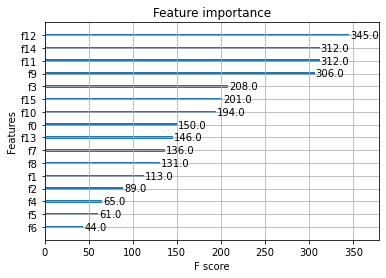

<Figure size 432x288 with 0 Axes>

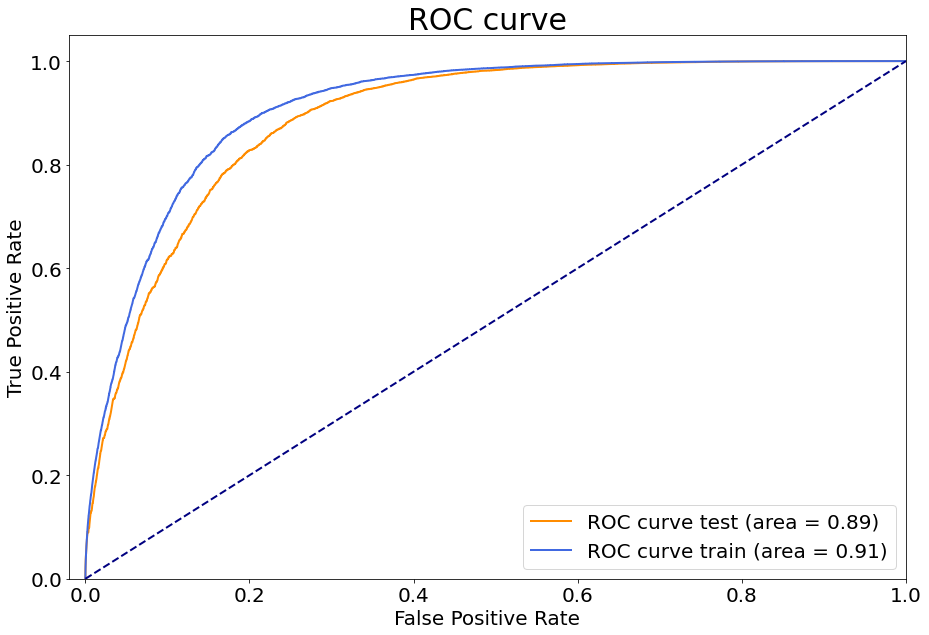

In [66]:
# Compute micro-average ROC curve and ROC area
fpr, tpr, _ = roc_curve(events[events_test]["train_label"], check, sample_weight=abs(events[events_test]["weight_central"]))
fpr_train, tpr_train, _train = roc_curve(events[events_train]["train_label"], check_train, sample_weight=abs(events[events_train]["weight_central"]))
roc_auc = auc(fpr, tpr)
roc_auc_train = auc(fpr_train, tpr_train)
xgboost.plot_importance(bdt)
lw = 2
plt.figure(figsize=(15,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve test (area = %0.2f)' % roc_auc)
plt.plot(fpr_train, tpr_train, color='royalblue',
         lw=lw, label='ROC curve train (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC curve', fontsize=30)
plt.legend(loc="lower right", fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.show()

{'train': OrderedDict([('auc', [0.855889, 0.866663, 0.868334, 0.869144, 0.871524, 0.873444, 0.87649, 0.876357, 0.878423, 0.878751, 0.87944, 0.879478, 0.879844, 0.879631, 0.87985, 0.880275, 0.881109, 0.881548, 0.88185, 0.882097, 0.882522, 0.882678, 0.8829, 0.883223, 0.884082, 0.884358, 0.884542, 0.885669, 0.886171, 0.886558, 0.887133, 0.887212, 0.887722, 0.888061, 0.888182, 0.8884, 0.888582, 0.888821, 0.888955, 0.889295, 0.889593, 0.890141, 0.890357, 0.890543, 0.890824, 0.89139, 0.891671, 0.891946, 0.892012, 0.892443, 0.892904, 0.893136, 0.893455, 0.893858, 0.89407, 0.894445, 0.894703, 0.894821, 0.895049, 0.895248, 0.89536, 0.895867, 0.896424, 0.896959, 0.897185, 0.897565, 0.897613, 0.897852, 0.898082, 0.898515, 0.898753, 0.89887, 0.899176, 0.89951, 0.89975, 0.899863, 0.899933, 0.900139, 0.900283, 0.900394, 0.900478, 0.900646, 0.900783, 0.900907, 0.901089, 0.901388, 0.901649, 0.90179, 0.901891, 0.902057, 0.902184, 0.902261, 0.902453, 0.902554, 0.902695, 0.902885, 0.903002, 0.903149, 0.9

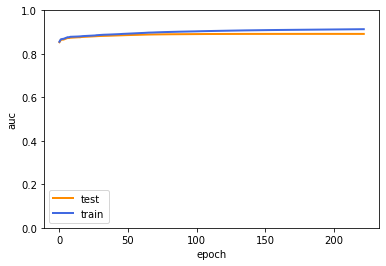

In [67]:
plt.figure()
key="auc"
plt.plot(np.arange(len(progress["test"][key])), progress["test"][key], color="darkorange", lw=lw, label='test')
plt.plot(np.arange(len(progress["train"][key])), progress["train"][key], color="royalblue", lw=lw, label='train')
plt.xlabel("epoch")
plt.ylabel(key)
if key == 'auc':
    plt.ylim([0., 1.0])
elif key == "error":
    plt.ylim([0.15, 0.5])
    
plt.legend()
plt.show()

In [68]:
del features_train 
del features_test 
del d_train 
del d_test 

In [69]:
# Predict
features = awkward.to_numpy(events[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
events["mva_score"] = bdt.predict(xgboost.DMatrix(features))

54.08608937483533 36.07291899160643


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


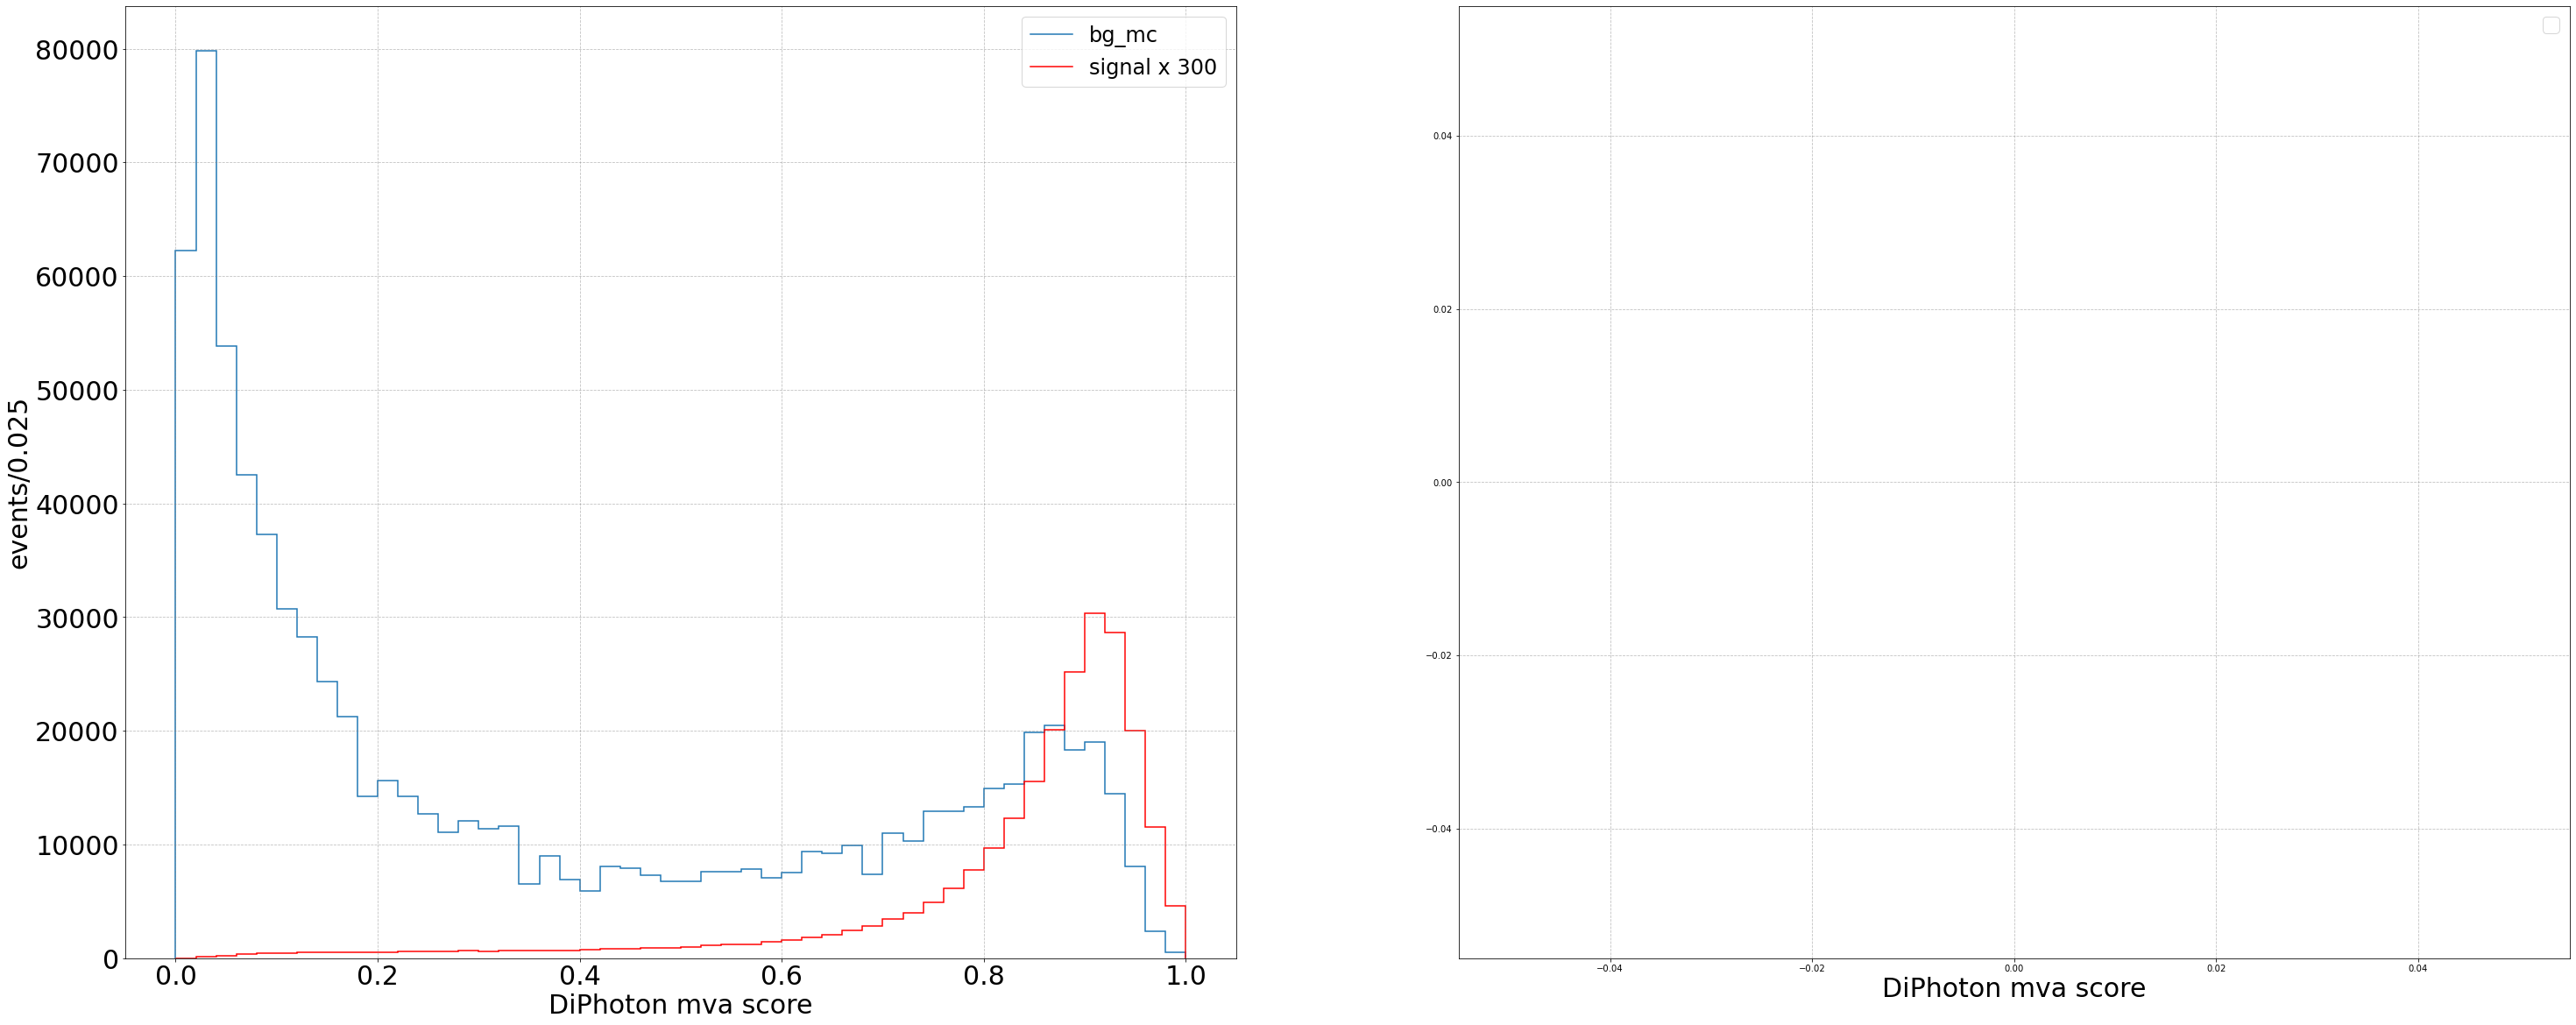

In [70]:
import hist
from hist import *
sig_norm     = awkward.sum(events.weight_central_no_lumi[(events.process_id < 5)&(events.process_id >0)])
sig_integral = awkward.sum(events.weight_central_no_lumi[(events["train_split"]>0)&(events.process_id <5)&(events.process_id >0)])
print(sig_norm,sig_integral)
#bdt_score
fig, axs = plt.subplots(1,2, figsize=(50, 20))
min_=-0
max_=1
nbins=50
h_bdt_score_tot       = Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_bg        = Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_tot.fill(bdt_score_tot=events.mva_score[(events.process_id>0)&(events.process_id<5)&(events.train_split>0)],     weight=events.weight_central_no_lumi[(events.process_id<5)&(events.train_split>0)])
h_bdt_score_bg.fill( bdt_score_tot=events.mva_score[(events.process_id>4)&(events.train_split>0)],     weight=events.weight_central_no_lumi[(events.process_id>4)&(events.train_split>0)])


h_bdt_score_tot=h_bdt_score_tot*300*sig_norm/sig_integral*14.5
h_bdt_score_bg=h_bdt_score_bg*norm/integral*14.5

h_bdt_score_bg.project("bdt_score_tot").plot(ax=axs[0], label="bg_mc")
h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs[0], color="red", label="signal x 300")

for i in range(2):
    axs[i].legend( prop={'size': 24})
    axs[i].grid(color='grey', linestyle='--', alpha=0.5)
    #if i == 0:
    #    axs[i].set_title('DiPhoton mva score after retraining for standard signal and bg mc', fontsize=30)
    #if i == 1:
    #    axs[i].set_title('DiPhoton mva score before retraining for standard signal and bg mc', fontsize=30)
    axs[0].set_ylabel('events')
    axs[i].set_xlabel('DiPhoton mva score', fontsize=30)
    axs[0].set_ylabel('events/0.025', fontsize=30)
    axs[0].tick_params(axis='x', labelsize=30)
    axs[0].tick_params(axis='y', labelsize=30)
    
plt.plot()
plt.show()

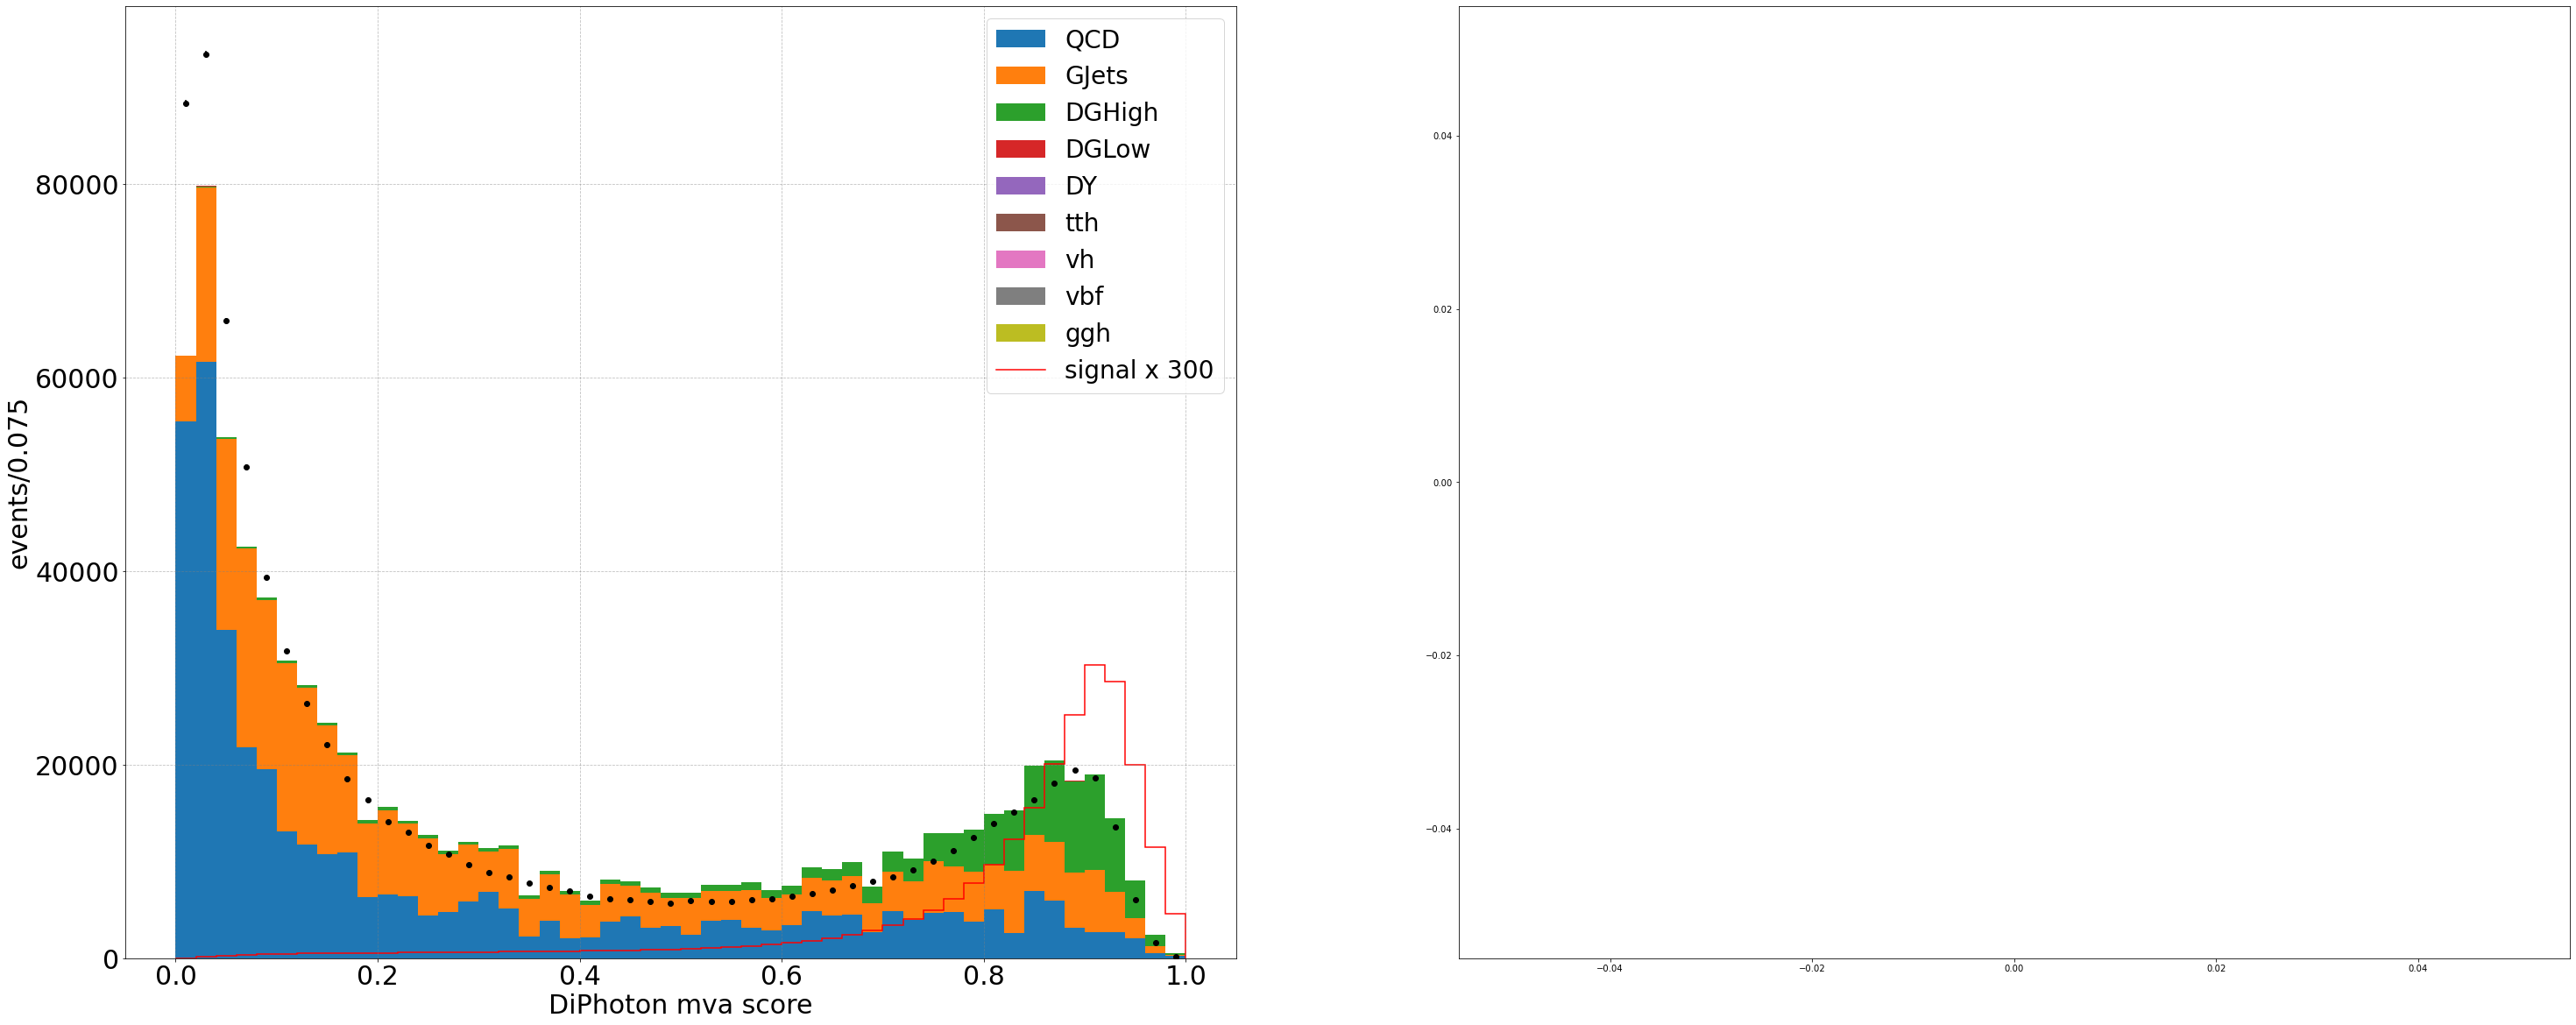

In [71]:
delete = True
#bdt_score
fig, axs = plt.subplots(1,2, figsize=(50, 20))
if(delete):
    LeadPhoton_et_ax  = hist.axis.Regular(nbins, min_, max_, flow=False, name="bdt_score_tot")
    LeadPhoton_et_cax = hist.axis.StrCategory(["ggh", "vbf", "vh", "tth", "DY", "DGLow", "DGHigh", "GJets", "QCD"], name="c")
    full_hist = Hist(LeadPhoton_et_ax, LeadPhoton_et_cax)

    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 1)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 1)&(events.train_split>0)], c="ggH")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 4)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 4)&(events.train_split>0)], c="vbf")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 2)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 2)&(events.train_split>0)], c="vh")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 3)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 3)&(events.train_split>0)], c="tth")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 5)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 5)&(events.train_split>0)], c="DGLow")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 6)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 6)&(events.train_split>0)], c="DGHigh")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id == 7)&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id == 7)&(events.train_split>0)], c="QCD")
    full_hist.fill( bdt_score_tot=events.mva_score[(events.process_id > 7 )&(events.train_split>0)], weight=events.weight_central_no_lumi[(events.process_id  > 7)&(events.train_split>0)], c="GJets")

full_hist=(full_hist*14.5/integral*norm) #normalized to match 14.5 /fb of analized data
h_stack = full_hist.stack("c")

h_stack[::-1].plot(ax=axs[0], stack=True, histtype="fill")
h_bdt_score_tot.project("bdt_score_tot").plot(ax=axs[0], color="red", label="signal x 300")
axs[0].legend( prop={'size': 28})
axs[0].grid(color='grey', linestyle='--', alpha=0.5)

if (delete):
    del events
    del features

data = awkward.values_astype(data, np.float64)
features = awkward.to_numpy(data[bdt_config["features"]])
features = features.view((float, len(features.dtype.names)))
data["mva_score"] = bdt.predict(xgboost.DMatrix(features))

h_bdt_score_data      = Hist(hist.axis.Regular(bins=nbins,   start=min_, stop=max_, name="bdt_score_tot", label="tot"))
h_bdt_score_data.fill(bdt_score_tot=data.mva_score, weight=data.weight_central)

bins_data, edges_data = h_bdt_score_data.to_numpy()
bins_err   = np.sqrt(bins_data)
edges_data = np.resize(edges_data, nbins)
edges_data = edges_data + np.abs((edges_data[1]-edges_data[0]))/2
dump = np.logical_or((edges_data < 120),(edges_data > 130))
axs[0].errorbar(edges_data[dump],bins_data[dump], yerr=bins_err[dump], color="black", marker="o", linestyle="", label="data")

   
axs[0].set_ylabel('events')
axs[0].set_xlabel('DiPhoton mva score', fontsize=30)
axs[0].set_ylabel('events/0.075', fontsize=30)
axs[0].tick_params(axis='x', labelsize=30)
axs[0].tick_params(axis='y', labelsize=30)

    
plt.plot()
plt.show()

In [72]:
# retrieve performance metrics
results = bdt.eval_set()
print(results)
#epochs = len(results['validation_0']['error'])
#x_axis = range(0, epochs)

TypeError: Booster.eval_set() missing 1 required positional argument: 'evals'

In [ ]:
bdt